## *Import Used Libraries*

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings(action='ignore')

## *Loading Images File*

In [2]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

## *Preparing Images For Training By Image Preprocessing*

In [3]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)
val_datagen=ImageDataGenerator()

In [4]:
train= train_datagen.flow_from_directory(train_dir,batch_size=128,target_size=(230,230),color_mode='rgb',class_mode='categorical',seed=42)
valid=val_datagen.flow_from_directory(valid_dir,batch_size=128,target_size=(230,230),color_mode='rgb',class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## *Model1 ResNet50*

In [5]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(230,230,3),classes=38)
base_model_tf.trainable=False
pt=Input(shape=(230,230,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(32,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)
Model_1=Model(inputs=pt,outputs=model_resnet)
Model_1.summary()

2022-11-15 10:23:21.133750: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 230, 230, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 230, 230, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 230, 230, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 230, 230, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
______________________________________________________________

In [6]:
Model_1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history =Model_1.fit(train,validation_data=valid,epochs=2,verbose=1,callbacks=[callback])

2022-11-15 10:23:25.402620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
550/550 [==============================] - 6330s 12s/step - loss: 0.7147 - accuracy: 0.8043 - val_loss: 0.2303 - val_accuracy: 0.9253
Epoch 2/2
550/550 [==============================] - 6344s 12s/step - loss: 0.1791 - accuracy: 0.9432 - val_loss: 0.1592 - val_accuracy: 0.9463


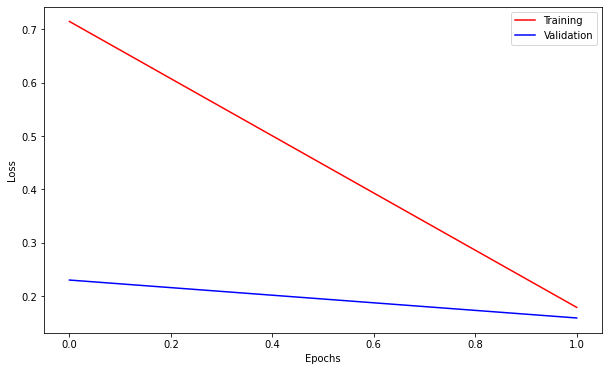

In [7]:
loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

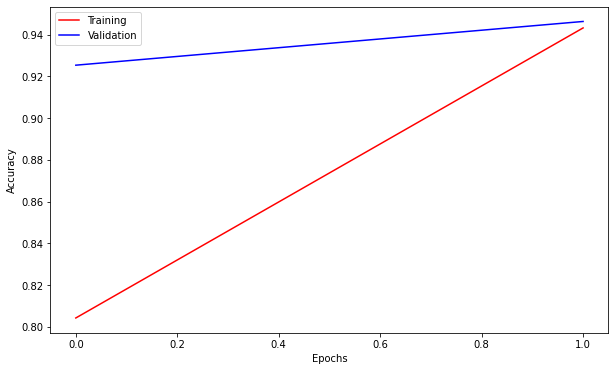

In [8]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [9]:
Model_1.save("model1.h5")

In [10]:
model_file = Model_1.to_json()
with open("model.json", "w") as source:
    source.write(model_file)
Model_1.save_weights("model1_weights.h5")